In [6]:
import numpy as np
#загрузка нужных результатов предсказания
path = "/Users/pochtalionizm/Projects/neuro/neuro_tools/results/03-16_16:07_0.0-11.4_AP018033.1_Mycobacterium"
seq_np = np.load(path + "/seq_np.npy")
mask = np.load(path + "/mask.npy")
out_np = np.load(path + "/00010_out_np.npy")
info = open(path + "/info.txt")
for line in info.readlines():
    print(line, end = "")
info.close()

03-16_16:07
0500000_000000000_0.0-11.4_47592_AP018033.1_Mycobacterium_tuberculosis_DNA,_complete_genome,_strain:_HN-024
skip_depth6,reflection,net,adam,noise,32,0.01,0.03,101,False,189300,[128, 128, 128],[128, 128, 128],[128, 128, 128],3,3,nearest,1,True,True,reflection,LeakyReLU
skip_depth6,reflection,net,adam,noise,32,0.01,0.03,101,False,189300,[128, 128, 128],[128, 128, 128],[128, 128, 128],3,3,nearest,1,True,True,reflection,LeakyReLU
skip_depth6,reflection,net,adam,noise,32,0.01,0.03,101,False,189300,[128, 128, 128],[128, 128, 128],[128, 128, 128],3,3,nearest,1,True,True,reflection,LeakyReLU
skip_depth6,reflection,net,adam,noise,32,0.01,0.03,101,False,189300,[128, 128, 128],[128, 128, 128],[128, 128, 128],3,3,nearest,1,True,True,reflection,LeakyReLU
skip_depth6,reflection,net,adam,noise,32,0.01,0.03,11,False,189300,[128, 128, 128],[128, 128, 128],[128, 128, 128],3,3,nearest,1,True,True,reflection,LeakyReLU


In [3]:
#функция сравнения
def compare(seq_np, out_np):
    if len(seq_np) != len(out_np):
        print("error")
        return None
    
    length = len(seq_np[0])

    out_array = np.zeros((4,length)) #array analog to seq_np
    for i in range(length):
        n = np.argmax(out_np[:, i])
        out_array[n, i] = 1
            
    diff = np.zeros(length)
    diff_discrete = np.zeros(length)
    for i in range(length):
        a = out_array[:, i]
        b = seq_np[:, i]
        r = np.linalg.norm(a-b)
        diff[i] = r
        if r > 1:
            diff_discrete[i] = 1
    return diff, diff_discrete

In [22]:
#возвращает массив расстояний между исходником и предсказанием
diff, diff_discrete = compare(seq_np, out_np)

In [23]:
def generate_counter(diff, mask, coding = None):
    if len(diff) != len(mask):
        print("error in length")
        return None
    length = len(diff)
    length_mask = sum(mask)
    
    c = {}
    c["all_mist"] = sum(diff)
    c["mask_mist"] = sum(diff * mask)
    c["free_mist"] = sum(diff) - sum(diff * mask)

    if c["all_mist"] != c["mask_mist"] + c["free_mist"]:
        print("error in counter")
    
    c["mask_part"] = c["mask_mist"] / length_mask
    c["free_part"] = c["free_mist"] / (length - length_mask)
    
       
    if coding != None:
        c["coding_mask"] = sum(mask * coding)
        c["noncoding_mask"] = sum(mask) - sum(mask * coding)
        
        if c["coding_mask"]+ c["noncoding_mask"] != length_mask:
            print("error in counter")
        
        c["coding_mask_mist"] = sum(diff * mask * coding)
        c["noncoding_mask_mist"] = sum(diff * mask) - sum(diff * mask * coding)
        
        if c["coding_mask_mist"]+c["noncoding_mask_mist"] != c["mask_mist"]:
            print("error in counter")

        c["coding_part"] = c["coding_mask_mist"] / c["coding_mask"]
        c["noncoding_part"] = c["noncoding_mask_mist"] / c["noncoding_mask"]
    
    return c


In [24]:
generate_counter(diff_discrete, mask)

{'all_mist': 4.0,
 'mask_mist': 0.0,
 'free_mist': 4.0,
 'mask_part': 0.0,
 'free_part': 8.840951286358412e-06}

In [7]:
import torch

In [11]:
net = torch.load(path + "/net.pty")

Про консервативность

In [1]:
import pyBigWig
import numpy as np

In [2]:
#файл с треком генома человека сборка 38
track_file = "/Users/pochtalionizm/Projects/neuro/data/hg38.phastCons20way.bw"

In [3]:
bw = pyBigWig.open(track_file)
bw.chroms()
bw.chroms("chr2")

242193529

2019-02-25_19:00:56
skip_depth6,reflection,net,adam,noise,32,0.01,0.03,4001,True,646788
0500000_007500000_3.1-3.3_47555_NC_000002.12_Homo_sapiens_chromosome_2,_GRCh38.p12_Primary_Assembly
net = skip(input_depth, seq_np.shape[0], #change skip function in models/skip.py
               num_channels_down = [128] * 3,
               num_channels_up =   [128] * 3,
               num_channels_skip =    [128] * 3,  
               filter_size_up = 3, filter_size_down = 3, 
               upsample_mode='nearest', filter_skip_size=1,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)

In [51]:
#выбор нужной части трека 
track_part = bw.values("chr2", 6000000, 6500000, numpy = True)
len(track_part)

500000

In [54]:
print("seq length", len(diff))
print("mistakes", sum([1 for x in diff if x > 0.01]))

seq length 500000
mistakes 350126


In [55]:
#выбираем часть под маской
mask_diff = []
mask_track_part = []
free_diff = []
free_track_part = []
for i in range(len(diff)):
    if not (isinstance(diff[i], float) or isinstance(track_part[i], float)):
        print("None")
        
    if mask[i]==1:
        mask_diff.append(diff[i])
        mask_track_part.append(track_part[i])
    else:
        free_diff.append(diff[i])
        free_track_part.append(track_part[i])

print(len(mask_diff) + len(free_diff))
print(len(free_track_part) + len(mask_track_part))

500000
500000


In [56]:
max(free_diff)

1.4142135623730951

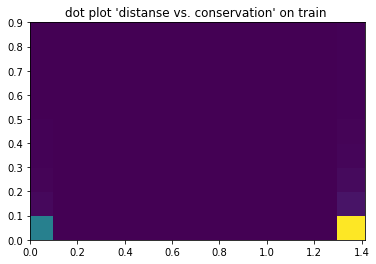

In [57]:
import matplotlib.pyplot as plt
# plt.plot(free_diff, free_track_part, "r,")
plt.hist2d(free_diff, free_track_part, bins = [[0, 0.1, 1.3, max(free_diff)], np.arange(0, 1, 0.1)])
plt.title("dot plot 'distanse vs. conservation' on train ")
# plt.xlabel("distance")
# plt.ylabel("value of conservation")
plt.show()
# plt.savefig("/Users/pochtalionizm/Projects/neuro/results/3/hist2d_1.png")

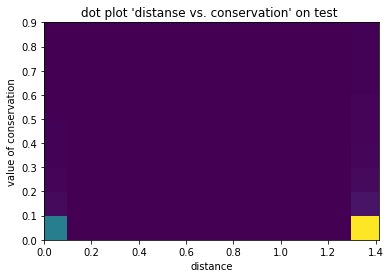

In [58]:
import matplotlib.pyplot as plt
# plt.plot(mask_diff, mask_track_part, "r,")
plt.hist2d(mask_diff, mask_track_part, bins = [[0, 0.1, 1.3, max(mask_diff)], np.arange(0, 1, 0.1)])
plt.title("dot plot 'distanse vs. conservation' on test ")
plt.xlabel("distance")
plt.ylabel("value of conservation")
plt.show()
# plt.savefig("/Users/pochtalionizm/Projects/neuro/results/3/hist2d_2.png")

14166
47555


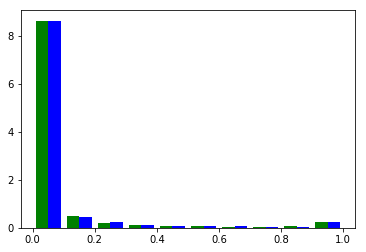

In [59]:
track_mask_for_small_d = [mask_track_part[i] for i in range(len(mask_diff)) if mask_diff[i]-0.0<0.1 ]
track_mask_for_big_d = [mask_track_part[i] for i in range(len(mask_diff)) if mask_diff[i]-1.4<0.1 ]
print(len(track_mask_for_small_d ))
print(len(track_mask_for_big_d))
plt.hist([track_mask_for_small_d , track_mask_for_big_d ], color = ['green', 'blue'], density = True)
plt.title("")
plt.show()

135708
452445


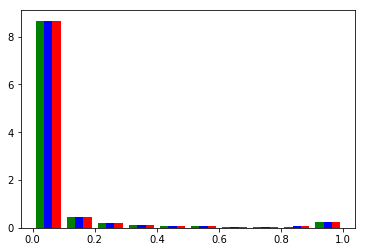

In [60]:
track_free_for_small_d = [free_track_part[i] for i in range(len(free_track_part)) if free_diff[i]-0.0<0.1 ]
track_free_for_big_d = [free_track_part[i] for i in range(len(free_track_part)) if free_diff[i]-1.4<0.1 ]
print(len(track_free_for_small_d))
print(len(track_free_for_big_d))
plt.hist([track_free_for_small_d, track_free_for_big_d, track_part], color = ['green', 'blue', "red"], density = True)
plt.show()

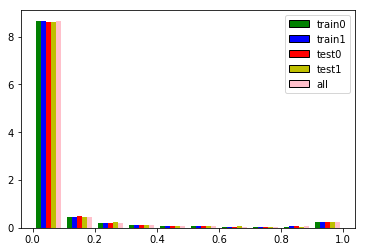

In [61]:
from matplotlib.patches import Rectangle
c = ['g', 'b', 'r', 'y' , 'pink']
plt.hist([track_free_for_small_d, track_free_for_big_d, track_mask_for_small_d, 
          track_mask_for_big_d, track_part], 
         color = c, density = True)

handles = [Rectangle((0,0),1,1,color=col,ec="k") for col in c]
labels= ['train0','train1','test0', 'test1', 'all' ]
plt.legend(handles, labels)
plt.show()
# plt.savefig("/Users/pochtalionizm/Projects/neuro/results/3/all_cons.png")

In [21]:
def plot_loss(path, save = False):
    loss = np.load(path + "/loss.npy")
    fig = plt.plot(loss)
    plt.ylabel('loss')
    plt.xlabel('iteration')
    plt.tight_layout()
#     if save:
#         plt.savefig("pics/loss_{}.png".format(self.file_title))
    plt.show()

In [22]:
plot_loss(path)

ModuleNotFoundError: No module named 'torch'